# 示例：RUL的不确定性预测（基于MC-Drop）
- author：键哥工作室

In [1]:
from rulframework.data.feature.RMSFeatureExtractor import RMSFeatureExtractor
from rulframework.data.raw.XJTUDataLoader import XJTUDataLoader
from rulframework.data.train.SlideWindowDataGenerator import SlideWindowDataGenerator
from rulframework.entity.Bearing import PredictHistory
from rulframework.predict.evaluator.Evaluator import Evaluator
from rulframework.predict.evaluator.metric.CI import CI
from rulframework.predict.evaluator.metric.Error import Error
from rulframework.predict.evaluator.metric.ErrorPercentage import ErrorPercentage
from rulframework.predict.evaluator.metric.MAPE import MAPE
from rulframework.predict.evaluator.metric.MSE import MSE
from rulframework.predict.evaluator.metric.Mean import Mean
from rulframework.predict.evaluator.metric.RUL import RUL
from rulframework.model.PytorchModel import PytorchModel
from rulframework.model.uncertainty.MLP_60_48_drop_32 import MLP_60_48_drop_32
from rulframework.predict.predictor.RollingPredictor import RollingPredictor
from rulframework.predict.confidence_interval.MeanPlusStdCICalculator import MeanPlusStdCICalculator
from rulframework.data.stage.BearingStageCalculator import BearingStageCalculator
from rulframework.data.stage.eol.NinetyThreePercentRMSEoLCalculator import NinetyThreePercentRMSEoLCalculator
from rulframework.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from rulframework.util.MovingAverageFilter import MovingAverageFilter
from rulframework.predict.ThresholdTrimmer import ThresholdTrimmer

## 加载西交大轴承数据集
- 获取轴承1-3的水平振动信号

In [2]:
data_loader = XJTUDataLoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
bearing = data_loader.get_bearing("Bearing1_3", columns='Horizontal Vibration')

成功登记以下轴承数据：
  Bearing1_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
  Bearing1_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
  Bearing1_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
  Bearing1_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
  Bearing1_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
  Bearing2_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
  Bearing2_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
  Bearing2_3，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
  Bearing2_4，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
  Bearing2_5，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
  Bearing3_1，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\40Hz10kN\Bearing3_1
  Bearing3_2，位置: D:\data\dataset\XJTU-SY_Bearing_Datasets\40Hz10kN\Bearing3_2
  Bearing3_3，位置: D:\data\dataset\XJTU-SY_B

## 输出原始振动信号图

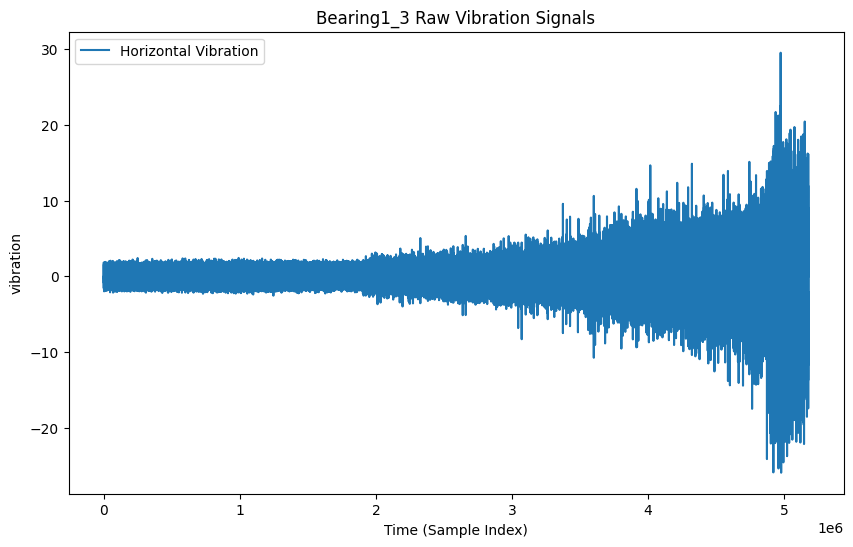

In [3]:
bearing.plot_raw()

## 使用RMS（均方根）提取特征

In [4]:
feature_extractor = RMSFeatureExtractor(32768)
bearing.feature_data = feature_extractor.extract(bearing.raw_data)

## 输出特征图

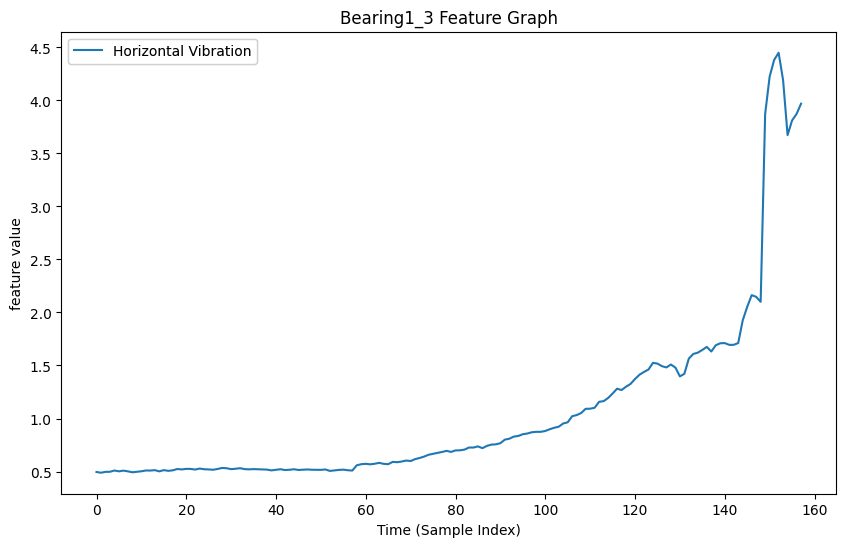

In [5]:
bearing.plot_feature()

## 划分轴承全寿命阶段
- 计算FPT
- 计算EoL
- 计算失效阈值

In [6]:
fpt_calculator = ThreeSigmaFPTCalculator()
eol_calculator = NinetyThreePercentRMSEoLCalculator()
stage_calculator = BearingStageCalculator(fpt_calculator, eol_calculator, 32768)
stage_calculator.calculate_state(bearing)

## 输出轴承的全寿命阶段划分图
- 平稳运行阶段
- 退化阶段
- 完全失效阶段

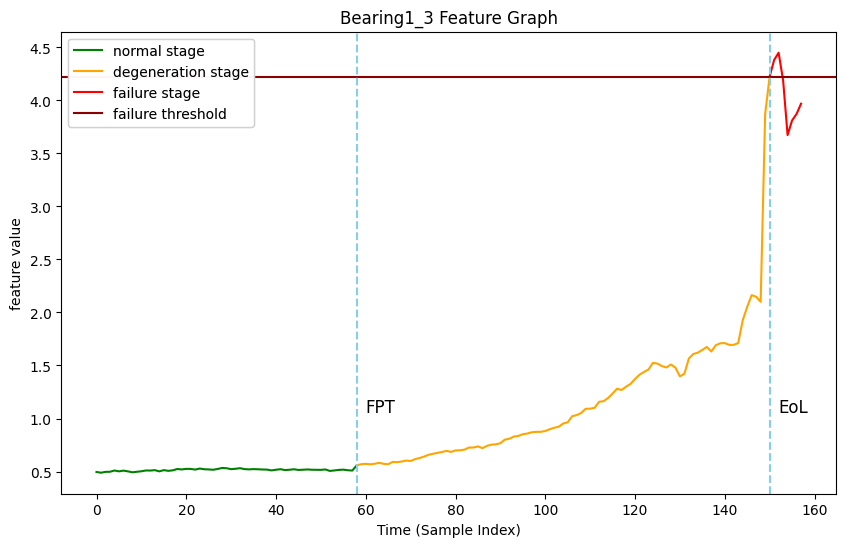

In [7]:
bearing.plot_feature()

## 使用滑动窗口生成训练数据

In [8]:
data_generator = SlideWindowDataGenerator(92)  # 输入大小60+输出大小32=92
bearing.train_data = data_generator.generate_data(bearing.feature_data)

## 定义模型并训练
- 待遇Dropout层的MLP（多层感知机）

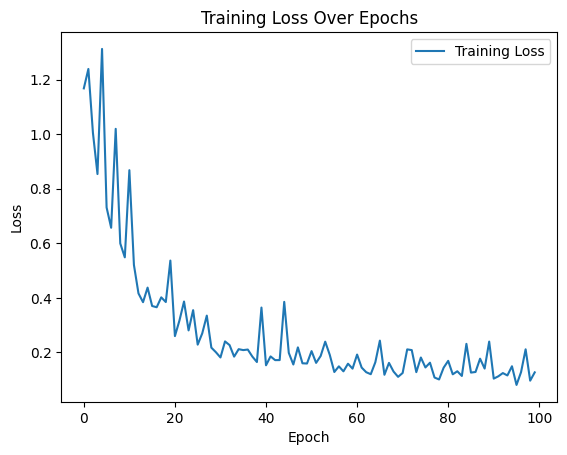

In [9]:
model = PytorchModel(MLP_60_48_drop_32())
model.train(bearing.train_data.iloc[:, :-32], bearing.train_data.iloc[:, -32:], 100)
model.plot_loss()

In [10]:
# 使用预测器进行预测
predictor = RollingPredictor(model)
ci_calculator = MeanPlusStdCICalculator(1.5)
input_data = bearing.feature_data.iloc[:, 0].tolist()[:60]
min_list, mean_list, max_list = predictor.predict_till_epoch_uncertainty(input_data, 5, ci_calculator)

In [11]:
# 使用移动平均滤波器平滑预测结果
average_filter = MovingAverageFilter(5)
min_list = average_filter.moving_average(min_list)
mean_list = average_filter.moving_average(mean_list)
max_list = average_filter.moving_average(max_list)

In [12]:
# 裁剪超过阈值部分曲线
predict_history = PredictHistory(58, lower=min_list, prediction=mean_list, upper=max_list)
trimmer = ThresholdTrimmer(bearing.stage_data.failure_threshold_feature)
bearing.predict_history = trimmer.trim(predict_history)

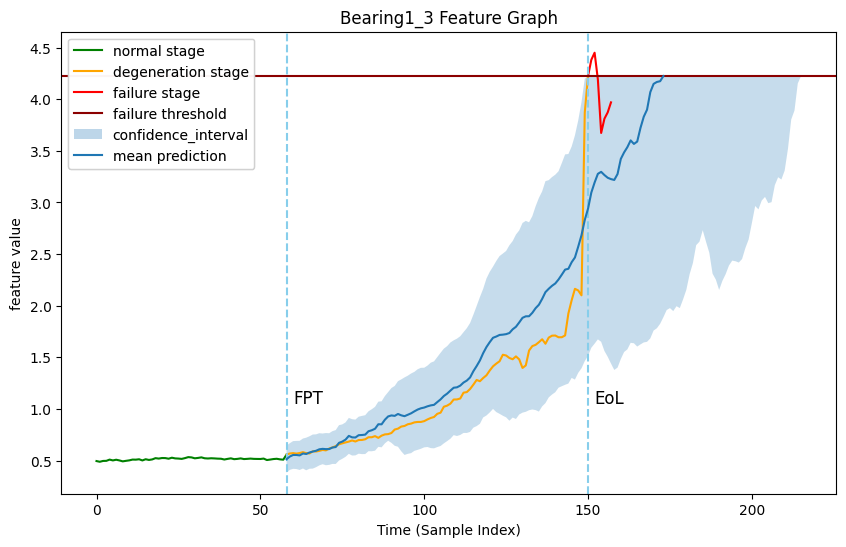

In [13]:
bearing.plot_feature()

## 计算评价指标

In [14]:
evaluator = Evaluator()
evaluator.add_metric(RUL(), Mean(), CI(), Error(), ErrorPercentage(), MSE(), MAPE())
evaluator.evaluate(bearing)

轴承Bearing1_3的预测结果评价：
  RUL： 92
  Median： 116
  95%CI： [92, 157]
  Error： 24
  Error percentage： 26.1%
  MSE： 0.0712
  MAPE： 14.0%
